Import used libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from itertools import chain
from keras.models import load_model

Download dataset, that previously was formed from DB

In [3]:
df = pd.read_csv("/content/filtered_300.csv", index_col=0)

Let's use not all of our data, but a little part of it for time economy. We will take 1000 latest records and 15 tickers. We are going to drop empty fileds, so our time series will have same not empty data points.

In [4]:
mini_df = df.tail(1000)
mini_df = mini_df[mini_df.columns[:15]]
mini_df.dropna(how='any', inplace=True)

In [5]:
mini_df

Cerner  Kennametal Inc  ...  Whirlpool  Wyndham Hotels & Resorts
2019-02-14  56.765        36.92715  ...    137.245                    50.830
2019-02-15  57.110        37.19065  ...    138.655                    51.555
2019-02-19  57.550        37.22045  ...    140.660                    52.040
2019-02-20  57.655        37.59335  ...    141.805                    52.840
2019-02-21  57.465        37.83200  ...    142.605                    53.365
...            ...             ...  ...        ...                       ...
2021-12-06  72.630        36.55000  ...    225.900                    79.990
2021-12-07  73.610        37.70500  ...    229.325                    81.630
2021-12-08  74.440        37.02500  ...    228.605                    82.505
2021-12-09  75.170        36.34000  ...    226.540                    82.100
2021-12-10  74.765        36.44500  ...    227.585                    82.310

[701 rows x 15 columns]

In [6]:
stockList = mini_df.columns

After droping empty values we've got 700 records. Let's split them for train and test as 500 and 200 records.

In [7]:
def split(dataframe, border):
    return dataframe.iloc[:border], dataframe.iloc[border:]

df_new = {}
for i in stockList:
    df_new[i] = {}
    df_new[i]["Train"], df_new[i]["Test"] = split(mini_df[i],500)

On figures below you can see some of our splitted time series.

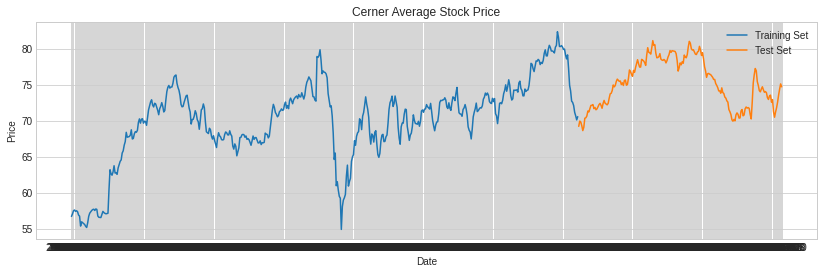

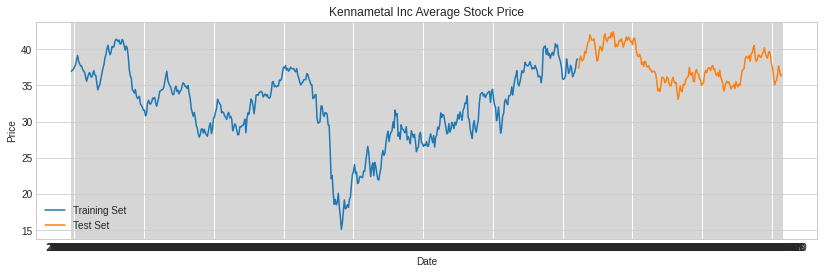

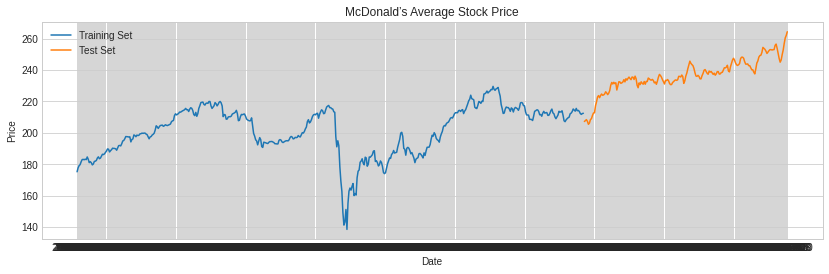

In [8]:
for i in stockList[:3]:
    plt.figure(figsize=(14,4))
    plt.plot(df_new[i]["Train"])
    plt.plot(df_new[i]["Test"])
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.title(i + " Average Stock Price")

We will rescale all stock price from 0 to 1. Each of company have their own scale. We make another two dictionary which contain scaled price for each company. One contain train set and another contain test set.

We also create another dictionary for collecting the scaller. This will be useful when we want to inverse transform our prediction.

In [9]:
# Scaling the training set
transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(stockList):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_new[i]["Train"])
    a1 = np.array(df_new[i]["Test"])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.fit_transform(a1)
    scaler[i] = sc
    
del a0
del a1

We will use 15 feature for training. We prepare shape our test and train set for neural network input

In [10]:
trainset = {}
testset = {}
for j in stockList:
    trainset[j] = {}
    X_train = []
    y_train = []
    for i in range(15,500):
        X_train.append(transform_train[j][i-15:i,0])
        y_train.append(transform_train[j][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset[j]["y"] = y_train
    
    testset[j] = {}
    X_test = []
    y_test = []    
    for i in range(15, 200):
        X_test.append(transform_test[j][i-15:i,0])
        y_test.append(transform_test[j][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test

We use LSTM model with 4 layers. For more architecture and parameters info look in the cell below.

In [11]:
%%time

regressor = Sequential()

regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))

regressor.add(Dense(units=1))


regressor.compile(optimizer='rmsprop', loss='mean_squared_error')

loss_history = []
for i in stockList[:20]:
    print("Fitting to", i)
    history_callback = regressor.fit(trainset[i]["X"], trainset[i]["y"], epochs=10, batch_size=200)
    loss_history.append(history_callback.history["loss"])

Fitting to Cerner
Epoch 1/10
3/3 [==============================] - 7s 69ms/step - loss: 0.2153
Epoch 2/10
3/3 [==============================] - 0s 72ms/step - loss: 0.0756
Epoch 3/10
3/3 [==============================] - 0s 72ms/step - loss: 0.0276
Epoch 4/10
3/3 [==============================] - 0s 70ms/step - loss: 0.0270
Epoch 5/10
3/3 [==============================] - 0s 72ms/step - loss: 0.0278
Epoch 6/10
3/3 [==============================] - 0s 83ms/step - loss: 0.0385
Epoch 7/10
3/3 [==============================] - 0s 71ms/step - loss: 0.0477
Epoch 8/10
3/3 [==============================] - 0s 66ms/step - loss: 0.0262
Epoch 9/10
3/3 [==============================] - 0s 68ms/step - loss: 0.0255
Epoch 10/10
3/3 [==============================] - 0s 75ms/step - loss: 0.0257
Fitting to Kennametal Inc
Epoch 1/10
3/3 [==============================] - 0s 74ms/step - loss: 0.0588
Epoch 2/10
3/3 [==============================] - 0s 70ms/step - loss: 0.0438
Epoch 3/10
3/3 [===

The figure below represents loss function

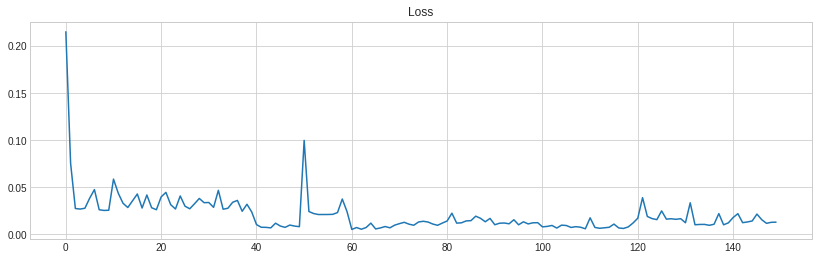

In [28]:
plt.figure(figsize=(14,4))
plt.title("Loss")
plt.plot(list(chain(*loss_history)))

Let's see how we predict time_series for 3 our ticker

[[71.73 ]
 [71.905]
 [71.575]
 [71.695]
 [71.98 ]
 [72.295]
 [72.47 ]
 [72.18 ]
 [71.785]
 [72.45 ]
 [72.875]
 [72.49 ]
 [72.375]
 [72.26 ]
 [72.465]
 [73.175]
 [73.785]
 [73.87 ]
 [74.24 ]
 [75.015]
 [74.76 ]
 [74.95 ]
 [75.5  ]
 [75.835]
 [75.68 ]
 [75.52 ]
 [75.57 ]
 [75.075]
 [75.32 ]
 [74.95 ]
 [75.65 ]
 [75.71 ]
 [74.985]
 [75.09 ]
 [75.94 ]
 [77.105]
 [76.875]
 [76.515]
 [76.225]
 [77.045]
 [76.78 ]
 [77.435]
 [77.965]
 [78.53 ]
 [77.965]
 [77.51 ]
 [77.505]
 [78.58 ]
 [78.48 ]
 [78.355]
 [78.12 ]
 [77.74 ]
 [79.165]
 [80.2  ]
 [79.565]
 [79.485]
 [79.31 ]
 [80.19 ]
 [81.18 ]
 [80.515]
 [80.625]
 [79.435]
 [78.8  ]
 [78.835]
 [78.95 ]
 [79.375]
 [78.61 ]
 [78.49 ]
 [78.435]
 [78.565]
 [78.435]
 [78.09 ]
 [78.41 ]
 [78.895]
 [79.23 ]
 [79.805]
 [79.545]
 [79.785]
 [79.75 ]
 [79.72 ]
 [79.68 ]
 [79.365]
 [78.435]
 [76.95 ]
 [77.435]
 [78.085]
 [77.825]
 [78.245]
 [78.04 ]
 [79.175]
 [78.91 ]
 [78.795]
 [79.265]
 [80.33 ]
 [81.08 ]
 [80.825]
 [80.06 ]
 [79.865]
 [79.915]
 [79.625]


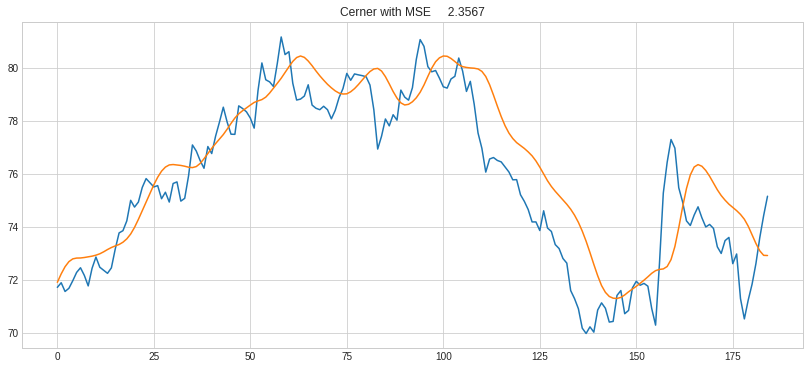

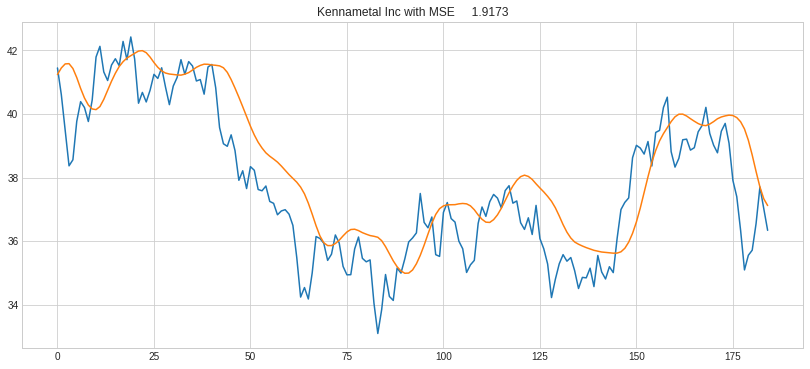

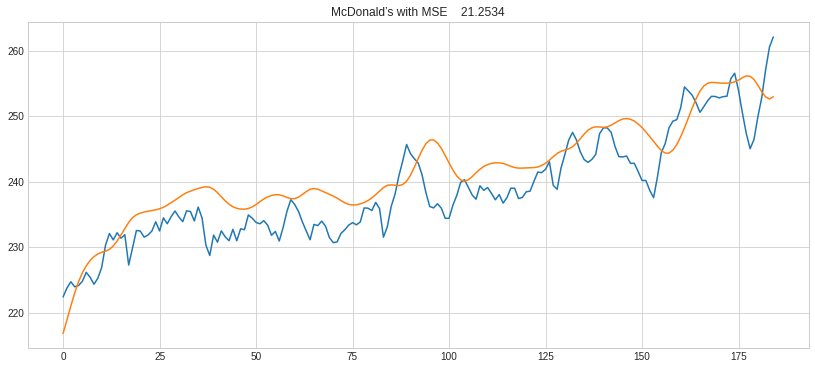

In [12]:
pred_result = {}
for i in stockList[:3]:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    print(y_true)
    y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred
    
    plt.figure(figsize=(14,6))
    plt.title("{} with MSE {:10.4f}".format(i,MSE))
    plt.plot(y_true)
    plt.plot(y_pred)

The following functions used to predict time series in server. 
- get_predict - returns predictions for certain number of days and time series plus predictions. Input:
  - model (Keras model) - model for predictions
  - ticker_name (str) - one of the 15 tickers, that were used
  - time_serie (List) - time serie for predictions
  - d (int) - number of days for predictions


- one_day_predict - returns predictions for 1 day for time serie. Input:
  - model (Keras model) - model for predictions
  - ser (np.array) - time serie

In [62]:
def load_model_from_file(path):
  return load_model(path)

def get_predict(model, ticker_name, time_serie, d):
  time_serie=np.array(time_serie)
  time_serie=time_serie.reshape(time_serie.shape[0],1)
  standarted_ts = scaler[ticker_name].fit_transform(time_serie)
  for i in range(d):
    one_day = one_day_predict(model, standarted_ts).reshape(-1,1)
    standarted_ts = np.append(standarted_ts,one_day)
  ts_transformed = scaler[ticker_name].inverse_transform(standarted_ts.reshape(-1,1))
  return ts_transformed[-d:], ts_transformed

def one_day_predict(model, ser):
    data = []
    for j in range(15,len(ser)):
      data.append(ser[j-15:j])
    data = np.array(data)
    data = data[:, :, np.newaxis]
    return model.predict(data)[-1]
